# Import

In [1]:
import os
# import pathlib
# import logging
import re
# import shutil
# import glob
# import pandas as pd
# import xml.etree.ElementTree as ET
# from tqdm import tqdm
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
import tarfile
# import time
# from collections import defaultdict
# from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import numpy as np

%load_ext tensorboard
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import tensorflow.compat.v1 as tf1
import contextlib2
import tensorflow as tf
import wget

from object_detection.utils import dataset_util
from object_detection.utils import label_map_util
# from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
# from object_detection.utils import colab_utils
from object_detection.builders import model_builder
from object_detection.dataset_tools import tf_record_creation_util


# Enable GPU dynamic memory allocation
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Training

In [3]:
#LINK : http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
model_name = "efficientdet_d0_coco17_tpu-32"
model = "efficientdet_d0_coco17_tpu-32.tar.gz"

# os.makedirs("pre_trained_models/", exist_ok=True)
download_tar = f"http://download.tensorflow.org/models/object_detection/tf2/20200711/{model}"
wget.download(download_tar, out="pre_trained_models/")

tar = tarfile.open(f"pre_trained_models/{model}")
tar.extractall(path="pre_trained_models/")
tar.close()

os.unlink(f"pre_trained_models/{model}")

In [4]:
import re

pipeline_path = "pre_trained_models/pipeline_olahan_daging.config"
fine_tune_checkpoint = "pre_trained_models/efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0"
train_input_path = "dataset/olahan_daging/train/food.tfrecord"
valid_input_path = "dataset/olahan_daging/valid/food.tfrecord"
label_map_path = "dataset/olahan_daging/train/food_label_map.pbtxt"
num_classes = 6
train_batch_size = 8
min_dim = 256
max_dim = 256

with open(pipeline_path) as f:
    pipeline_content = f.read()
with open(pipeline_path, 'w') as f:
    # change to finetune checkpoint path
    pipeline_content = re.sub('fine_tune_checkpoint: ".*?"',
               f'fine_tune_checkpoint: "{fine_tune_checkpoint}"', pipeline_content)

    # change to tfrecord path for train and validation
    pipeline_content = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', f'input_path: "{train_input_path}"', pipeline_content)
    pipeline_content = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', f'input_path: "{valid_input_path}"', pipeline_content)

    # change to label_map_path
    pipeline_content = re.sub(
        'label_map_path: ".*?"', f'label_map_path: "{label_map_path}"', pipeline_content)

    # Set training batch_size
    pipeline_content = re.sub(r'(train_config\s*{\s*batch_size:\s*)\d+', r'\g<1>{}'.format(train_batch_size), pipeline_content)

    # Set the dimension
    pipeline_content = re.sub('min_dimension: [0-9]+',
               f'min_dimension: {min_dim}', pipeline_content)
    pipeline_content = re.sub('max_dimension: [0-9]+',
               f'max_dimension: {max_dim}', pipeline_content)

    # Set number of classes num_classes.
    pipeline_content = re.sub('num_classes: [0-9]+',
               f'num_classes: {num_classes}', pipeline_content)

    # change the finetune type to detection
    pipeline_content = re.sub(
        'fine_tune_checkpoint_type: "classification"', f'fine_tune_checkpoint_type: "{"detection"}"', pipeline_content)

    f.write(pipeline_content)

#run on terminal

!python models/research/object_detection/model_main_tf2.py --pipeline_config_path=pre_trained_models/pipeline_olahan_daging.config --num_train_steps=20000 --model_dir=training/olahan_daging_efficientdet_d0 --alsologtostderr

#run on terminal with above so mAP score shows

!python models/research/object_detection/model_main_tf2.py --pipeline_config_path=pre_trained_models/pipeline_olahan_daging.config --model_dir=training/olahan_daging_efficientdet_d0 --checkpoint_dir=training/olahan_daging_efficientdet_d0 --alsologtostderr --eval_timeout=1000

#run on terminal

tensorboard --logdir=training/olahan_daging_efficientdet_d0

#run on terminal

!python models/research/object_detection/exporter_main_v2.py --trained_checkpoint_dir=training/olahan_daging_efficientdet_d0 --output_directory=custom_model_lite/olahan_daging_efficientdet_d0 --pipeline_config_path=pre_trained_models/pipeline_olahan_daging.config


# Testing

In [3]:
import cv2
%matplotlib inline

In [4]:
model_cat = [p.split("_efficientdet_d0")[0] for p in os.listdir("custom_model_lite")]
models = {}
category_indexs = {}

def read_label_file(label_path):
    id_pattern = r'id:\s*(\d+)'
    display_name_pattern = r'display_name:\s*"([^"]*)"'
    with open(label_path, 'r') as file:
        pbtxt_content = file.read()
        ids = [int(i) for i in re.findall(id_pattern,  pbtxt_content)]
        display_names = re.findall(display_name_pattern, pbtxt_content)
    result = {}
    for i in range(len(display_names)):
        result[ids[i]] = {'id': ids[i], 'name': display_names[i]}
    return result

for cat in model_cat:
    models[cat] = tf.saved_model.load(f"custom_model_lite\{cat}_efficientdet_d0\saved_model")
    category_indexs[cat] = read_label_file(f"dataset/{cat}/train/food_label_map.pbtxt")

In [418]:
x = -1

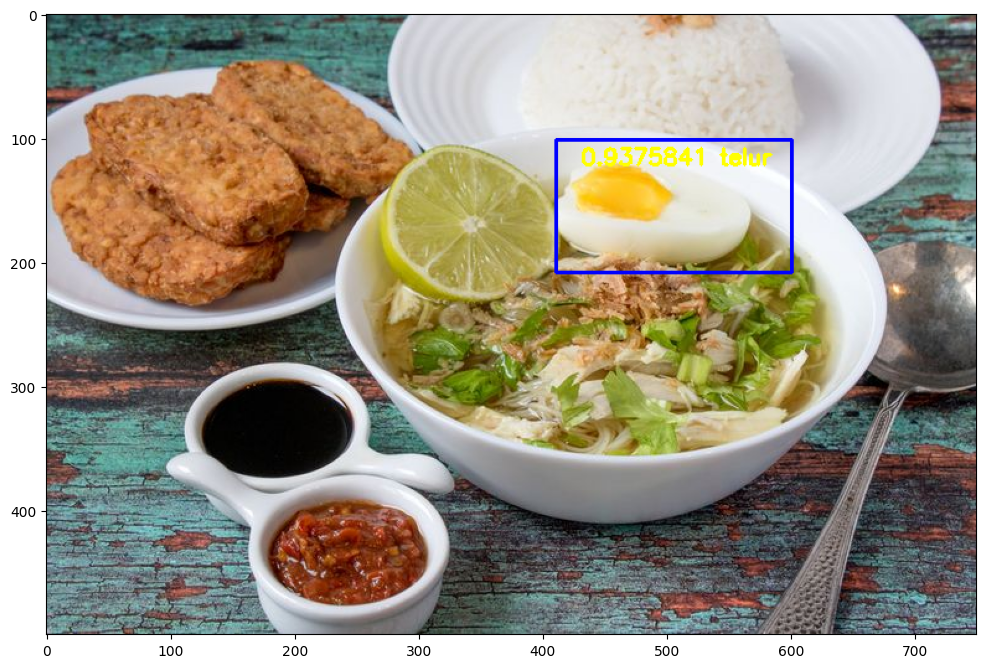

In [31]:
obj_detected = []
IMAGE_PATHS = r"testing\5f15325e9dc87.jpg"

image_np = np.array(Image.open(IMAGE_PATHS).convert("RGB"))
input_tensor = tf.convert_to_tensor(image_np, dtype=tf.uint8)
input_tensor = input_tensor[tf.newaxis, ...]
input_tensor = input_tensor[:, :, :, :3]

detections_arr = {}

# detect image with 6 models
for cat in model_cat:
    detections = models[cat]((input_tensor))
    detections_arr[cat] = detections
    classes = detections['detection_classes'][0].numpy()
    scores = detections['detection_scores'][0].numpy()
    for i in range(len(scores)):
        if((scores[i] > 0.5) and (scores[i] <= 1.0)):
            object_name = category_indexs[cat][classes[i]]
            obj_detected.append(object_name)

cat_testing = "lauk" # see certain model result
cat_index_testing = list(label_map_util.get_label_map_dict(f"dataset/{cat_testing}/train/food_label_map.pbtxt", use_display_name=True).keys())

image_np_with_annotations = image_np.copy()
h, w, d = image_np_with_annotations.shape

boxes_test = detections_arr[cat_testing]['detection_boxes'][0].numpy()
classes_test = detections_arr[cat_testing]['detection_classes'][0].numpy()
scores_test = detections_arr[cat_testing]['detection_scores'][0].numpy()

for ind in range(len(scores_test)):
    if scores_test[ind] >= 0.50:
        (xmin, xmax, ymin, ymax) = (int(boxes_test[ind][1] * w),
                                    int(boxes_test[ind][3] * w),
                                    int(boxes_test[ind][0] * h),
                                    int(boxes_test[ind][2] * h))
        cv2.rectangle(image_np_with_annotations, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
        cv2.putText(
        image_np_with_annotations,
        str(scores_test[ind]) + " "+ cat_index_testing[int(classes_test[ind] - 1)],
        (xmin + 20, ymin + 20),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX,
        fontScale = 0.6,
        color = (255, 255, 0),
        thickness=2
    )

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_annotations)
plt.show()